<a href="https://colab.research.google.com/github/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF/blob/main/EDAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blind Unmixing - EDAA

State-of-the-art blind unmixing method based on archetypal analysis for both endmembers and abundances estimation.

---

## Imports

1. Clone tutorial repository.
2. Install required Python packages.
3. Import Python packages.

In [ ]:
!git clone https://github.com/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF.git

Cloning into 'Unmixing_Tutorial_IEEE_IADF'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 97 (delta 41), reused 23 (delta 6), pack-reused 0
Unpacking objects: 100% (97/97), done.


In [ ]:
!pip install munkres

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import time
import os

import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import numpy.linalg as LA
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

from munkres import Munkres

In [2]:
from Unmixing_Tutorial_IEEE_IADF.utils.data import HSI
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import MeanSquareError as MSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import aRMSE as RMSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SADDegrees as SAD
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SRE
from Unmixing_Tutorial_IEEE_IADF.utils.aligners import MunkresAbundancesAligner as Aligner
from Unmixing_Tutorial_IEEE_IADF.utils.noises import AdditiveWhiteGaussianNoise as AWGN

## Data

---

Create a HSI data object.

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels'])
HSI => Sim1
---------------------
224 bands,
105 lines, 105 samples, (11025 pixels),
6 endmembers (['#0', '#1', '#2', '#3', '#4', '#5'])
GlobalMinValue: 0.0, GlobalMaxValue: 1.0



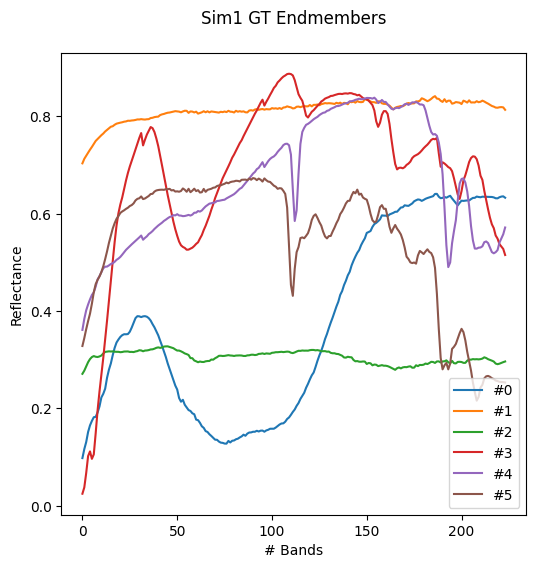

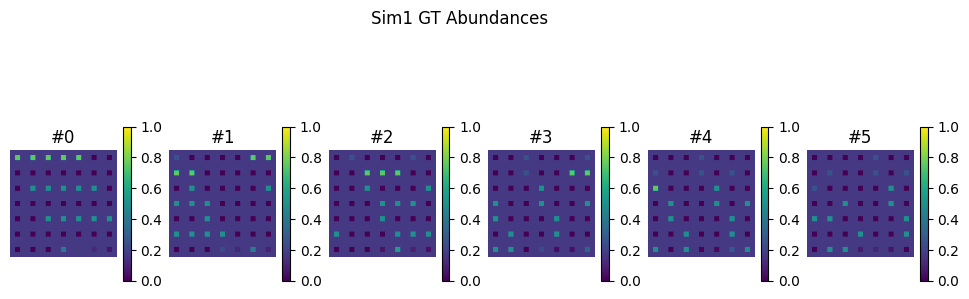

In [3]:
hsi = HSI("Sim1.mat")
print(hsi)
hsi.plot_endmembers()
hsi.plot_abundances()

In [4]:
class BlindEDAA:
    def __init__(self, T=100, K1=5, K2=5, M=50):
        self.T = T
        self.K1 = K1
        self.K2 = K2
        self.M = M

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def solve(
        self,
        Y,
        p,
        seed=0,
        **kwargs,
    ):
        best_E = None
        best_A = None

        L, N = Y.shape

        def residual(a, b):
            return 0.5 * ((Y - (Y @ b) @ a) ** 2).sum()

        def residual_l1(a, b):
            return (Y - (Y @ b) @ a).abs().sum()

        def loss(a, b):
            return residual(a, b)

        def grad_A(a, b):
            YB = Y @ b
            ret = -YB.t() @ (Y - YB @ a)
            return ret

        def grad_B(a, b):
            return -Y.t() @ ((Y - Y @ b @ a) @ a.t())

        def update(a, b):
            return F.softmax(torch.log(a) + b, dim=0)

        def computeLA(a, b):
            YB = Y @ b
            S = torch.linalg.svdvals(YB)
            return S[0] * S[0]

        max_correl = lambda e: np.max(np.corrcoef(e.T) - np.eye(p))

        results = {}

        tic = time.time()

        for m in tqdm(range(self.M)):
            torch.manual_seed(m + seed)
            generator = np.random.RandomState(m + seed)

            with torch.no_grad():

                # Matrix initialization
                B = F.softmax(0.1 * torch.rand((N, p)), dim=0)
                A = (1 / p) * torch.ones((p, N))

                # Send matrices on GPU
                Y = Y.to(self.device)
                A = A.to(self.device)
                B = B.to(self.device)

                # Random Step size factor
                factA = 2 ** generator.randint(-3, 4)

                # Compute step sizes
                self.etaA = factA / computeLA(A, B)
                self.etaB = self.etaA * ((p / N) ** 0.5)

                for ii in range(self.T):
                    for kk in range(self.K1):
                        A = update(A, -self.etaA * grad_A(A, B))

                    for kk in range(self.K2):
                        B = update(B, -self.etaB * grad_B(A, B))

                fit_m = residual_l1(A, B).item()
                E = (Y @ B).cpu().numpy()
                A = A.cpu().numpy()
                Xmap = B.t().cpu().numpy()
                Rm = max_correl(E)
                # Store results
                results[m] = {
                    "Rm": Rm,
                    "Em": E,
                    "Am": A,
                    "Bm": Xmap,
                    "fit_m": fit_m,
                    "factA": factA,
                }

        min_fit_l1 = np.min([v["fit_m"] for k, v in results.items()])

        def fit_l1_cutoff(idx, tol=0.05):
            val = results[idx]["fit_m"]
            return (abs(val - min_fit_l1) / abs(val)) < tol

        sorted_indices = sorted(
            filter(fit_l1_cutoff, results),
            key=lambda x: results[x]["Rm"],
        )

        best_result_idx = sorted_indices[0]
        best_result = results[best_result_idx]

        best_E = best_result["Em"]
        best_A = best_result["Am"]
        self.Xmap = best_result["Bm"]

        toc = time.time()
        elapsed_time = round(toc - tic, 2)
        print(f"{self} took {elapsed_time}s")

        return best_E, best_A

    def __repr__(self):
        msg = f"{self.__class__.__name__}"
        return msg

## Main pipeline

---

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels'])
Y shape: (224, 11025)
Desired SNR: 20
Sigmas after normalization: 0.0668153104781061
Sigma mean based on SNR: 0.9648830104929844
Final sigmas value: 0.06446895792113846


  0%|          | 0/50 [00:00<?, ?it/s]

BlindEDAA took 9.67s


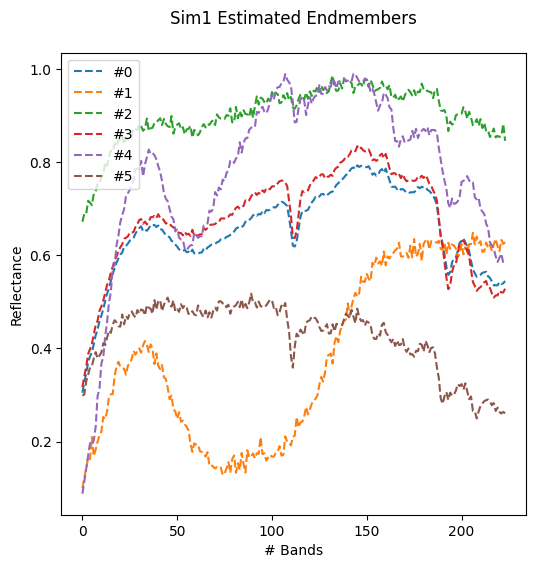

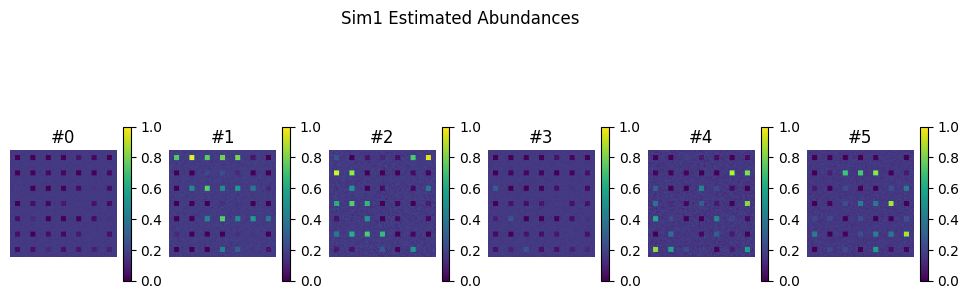

In [21]:
# Instantiate objects
model = BlindEDAA(K1=5, K2=5, T=100, M=50)
hsi = HSI("Sim1.mat")

noise = AWGN()

SNR = 20

hsi.Y = noise.fit_transform(hsi.Y, SNR=SNR, seed=0)

# Call data to return HSI (numpy format)
Y, _, _ = hsi()

# l2-normalize the data
#Y = Y / LA.norm(Y, axis=0, ord=2, keepdims=True)

# Convert the data to tensors
Y = torch.Tensor(Y)

# Abundances estimation
E0, A0 = model.solve(Y, hsi.p, seed=0)

# Plot results
hsi.plot_endmembers(E0=E0)
hsi.plot_abundances(A0=A0)

## Endmembers alignment

At this stage we need to align the endmembers and the abundances to compute the RMSE and SAD metrics.

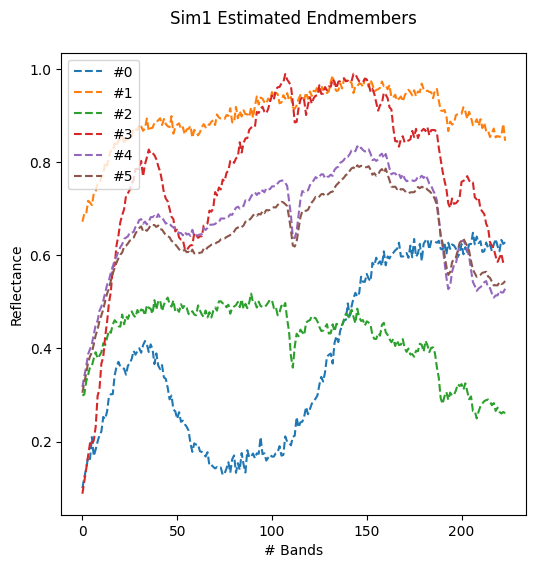

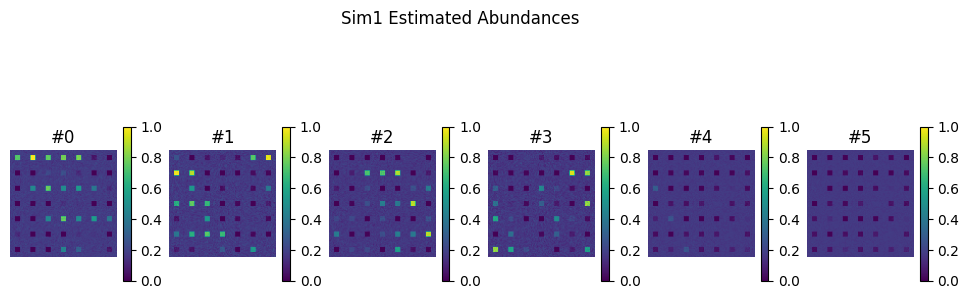

In [22]:
# Select a criterion to perform alignment
criterion = MSE()

# Select an aligner to perform alignment
aligner = Aligner(hsi=hsi, criterion=criterion)

A1 = aligner.fit_transform(A0)
E1 = aligner.transform_endmembers(E0)

# Plot alignment
hsi.plot_endmembers(E0=E1)
hsi.plot_abundances(A0=A1)

Notice how the materials were swapped.

## Quantitative results

---

We are now in shape to compute the abundances RMSE and endmembers SAD.

In [23]:
# Instantiate metrics
rmse = RMSE()
sad = SAD()
sre = SRE()

# Compute final numbers
print(f"RMSE => {rmse(hsi.A, A1):.2f}")
print(f"SAD => {sad(hsi.E, E1):.2f}")
print(f"SRE => {sre(hsi.A, A1):.2f}")

RMSE => 5.60
SAD => 5.40
SRE => 10.45


### Results for each material

In [ ]:
# Change the following line if you change dataset!
# Either comment out or describe each material name.
hsi.labels = ["Road", "Tree", "Roof", "Water"]
assert len(hsi.labels) == hsi.p

for ii, label in enumerate(hsi.labels):
    a, ahat = hsi.A[ii], A1[ii]
    print(f"RMSE ({label}) => {rmse(a, ahat):.2f}")

print("-" * 15)

for ii, label in enumerate(hsi.labels):
    e, ehat = hsi.E[:, ii][:, None], E1[:, ii][:, None]
    print(f"SAD ({label}) => {sad(e, ehat):.2f}")

RMSE (Road) => 13.62
RMSE (Tree) => 14.35
RMSE (Roof) => 11.83
RMSE (Water) => 16.90
---------------
SAD (Road) => 12.18
SAD (Tree) => 7.89
SAD (Roof) => 7.87
SAD (Water) => 2.20
